Source https://github.com/gastonstat/CreditScoring

To download the dataset, run

```
wget https://github.com/gastonstat/CreditScoring/raw/master/CreditScoring.csv
```

In [1]:
!head CreditScoring.csv

'head' is not recognized as an internal or external command,
operable program or batch file.


# Load the data 

In [8]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

## Data preparation

In [9]:
df = pd.read_csv('CreditScoring.csv')

In [10]:
df.head()

,Status,Seniority,Home,Time,Age,Marital,Records,Job,Expenses,Income,Assets,Debt,Amount,Price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


In [11]:
df.columns = df.columns.str.lower()
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,1,9,1,60,30,2,1,3,73,129,0,0,800,846
1,1,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,2,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,1,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,1,0,1,36,26,1,1,1,46,107,0,0,310,910


Categorical variables are represented by numbers. For converting, we'll use the following map (extracted from [Part1_CredScoring_Processing.R](https://github.com/gastonstat/CreditScoring/blob/master/Part1_CredScoring_Processing.R)). It's code in R which we'll translate to Pandas.

```
levels(dd$Status) = c("good", "bad")
levels(dd$Home) = c("rent", "owner", "priv", "ignore", "parents", "other")
levels(dd$Marital) = c("single", "married", "widow", "separated", "divorced")
levels(dd$Records) = c("no_rec", "yes_rec")
levels(dd$Job) = c("fixed", "partime", "freelance", "others")
```

Let's convert it:

In [12]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [13]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,1,60,30,2,1,3,73,129,0,0,800,846
1,ok,17,1,60,58,3,1,1,48,131,0,0,1000,1658
2,default,10,2,36,46,2,2,3,90,200,3000,0,2000,2985
3,ok,0,1,60,24,1,1,1,63,182,2500,0,900,1325
4,ok,0,1,36,26,1,1,1,46,107,0,0,310,910


In [14]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

In [15]:
marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

In [16]:
records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

In [17]:
job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [18]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


After this, all the categorical variables have strings, not numbers

Let's look at numberical variables:  

In [19]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


99999999 indicate missing values. Let's replace it by `NaN`: 

In [20]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [21]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

Now the stats are more meaninful

In [22]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


Let's look at the target variable

In [23]:
df.status.value_counts()

status
ok         3200
default    1254
unk           1
Name: count, dtype: int64

There's one record for which the status is unknown. Let's remove it - it's not useful for us

In [24]:
df = df[df.status != 'unk'].reset_index(drop=True)

In [25]:
df.isnull().sum()

status        0
seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       34
assets       47
debt         18
amount        0
price         0
dtype: int64

# prepare train Data

Now we're ready to prepare the data for training:

* First, do train-validation-test split
* Then, apply one-hot encoding to categorical features and get the feature matrix 

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=11)

In [28]:
y_train = (df_train.status == 'default').values
y_val = (df_val.status == 'default').values

In [29]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_val.status == 'default').astype('int').values

In [30]:
del df_train['status']
del df_val['status']
del df_test['status']

In [31]:
len(df_train), len(df_val), len(df_test)

(2672, 891, 891)

### manually : how it works 

In [198]:
df.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [199]:
def assess_risk(client):
    if client['records'] == 'yes':
        if client['job'] =='parttime':
            return 'default'
        else:
            return 'ok'
    else:
        if client['assets'] > 6000:
            return 'ok'
        else:
            return 'default'
        

In [200]:
xi = df_train.iloc[0].to_dict()

In [201]:
df_train.iloc[0]

seniority           10
home             owner
time                36
age                 36
marital        married
records             no
job          freelance
expenses            75
income             0.0
assets         10000.0
debt               0.0
amount            1000
price             1400
Name: 951, dtype: object

In [202]:
assess_risk(xi)

'ok'

### For OHE, we'll use `DictVectorizer`

In [34]:
from sklearn.feature_extraction import DictVectorizer

Remember that we have some missing values:

In [35]:
df_train.isnull().sum()

seniority     0
home          0
time          0
age           0
marital       0
records       0
job           0
expenses      0
income       25
assets       30
debt         11
amount        0
price         0
dtype: int64

We'll replace them with "0" like in Chapter 2

In [36]:
dict_train = df_train.fillna(0).to_dict(orient='records')
dict_val = df_val.fillna(0).to_dict(orient='records')

In [37]:
dict_train[0]

{'seniority': 10,
 'home': 'owner',
 'time': 36,
 'age': 36,
 'marital': 'married',
 'records': 'no',
 'job': 'freelance',
 'expenses': 75,
 'income': 0.0,
 'assets': 10000.0,
 'debt': 0.0,
 'amount': 1000,
 'price': 1400}

In [38]:
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

Now we're ready to train a model. We'll start with decision trees

## Decision trees

We'll use `DecisionTreeClassifier` and for evaluating the quality of our models, we'll use AUC


In [208]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

Let's fit the tree with default parameters

In [209]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


To get the predictions (probabilities), we use `predict_proba`. Let's check AUC on train data:

In [210]:
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

#### overfitting 

why it happens with decision trees ?

after all the conditions we may have only one person left !
it memorizes the data 

solution learning rules that are less specific


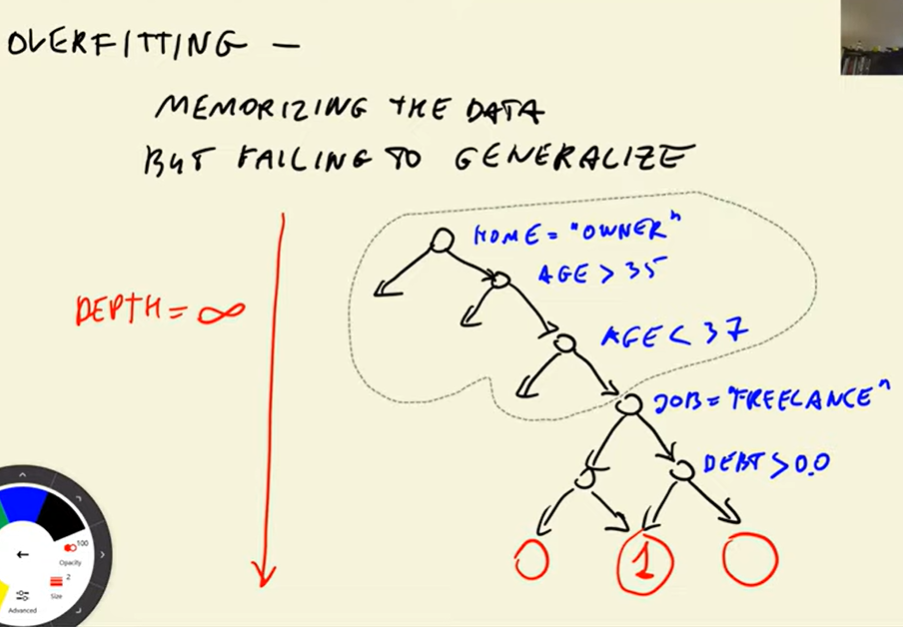



And on validation:

In [211]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6648331355501198

### changing the depth parameter

That's a case of _overfitting_ - our model on the training data performs perfectly, but fails on validation

Let's change the depth parameter: restring the size of the tree to 2 levels:

In [212]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train auc: %.3f' % auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val auc: %.3f' % auc)

train auc: 0.705
val auc: 0.669


It's even better than the previous tree!

### visualize trees 

In [213]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=yes <= 0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1
|--- records=yes >  0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0



### small example

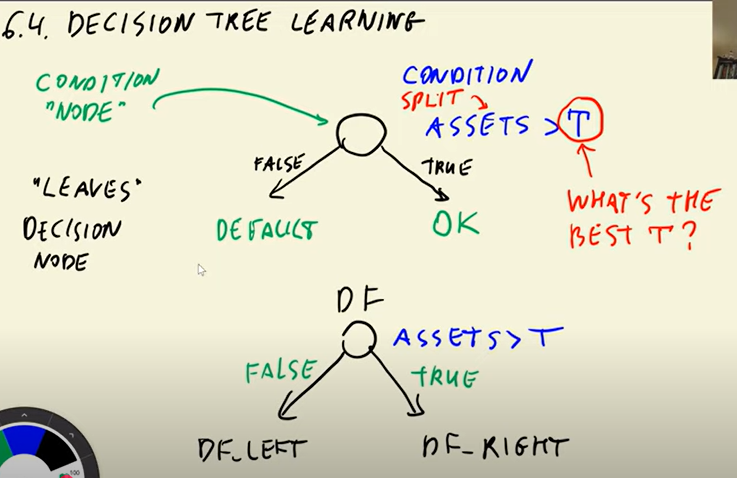

In [150]:
from IPython.display import display


In [151]:
data =[ [8000, 'default'],
       
        [2000, 'default'],
        [0, 'default'],
         [5000, 'ok'],
         [4000, 'ok'],
         [9000, 'ok'],
         [3000, 'default'],
        
        
      ]

In [152]:
df_example = pd.DataFrame(data, columns = ['assets','status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,4000,ok
5,9000,ok
6,3000,default


In [153]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
6,3000,default
4,4000,ok
3,5000,ok
0,8000,default
5,9000,ok


In [170]:
# potential theresholds
Ts =[8000, 2000, 5000,4000,3000]
# cut dataset to L and R for each T


In [173]:
for T in Ts:
    print(T)
    df_L= df_example[df_example.assets <=T]
    display(df_L)
    print(df_L.status.value_counts(normalize=True))
    df_R = df_example[df_example.assets >T]
    display(df_R)
    print(df_R.status.value_counts(normalize=True))
    



8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,4000,ok
6,3000,default


status
default    0.666667
ok         0.333333
Name: proportion, dtype: float64


,assets,status
5,9000,ok


status
ok    1.0
Name: proportion, dtype: float64
2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,4000,ok
5,9000,ok
6,3000,default


status
ok         0.6
default    0.4
Name: proportion, dtype: float64
5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,4000,ok
6,3000,default


status
default    0.6
ok         0.4
Name: proportion, dtype: float64


,assets,status
0,8000,default
5,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64
4000


,assets,status
1,2000,default
2,0,default
4,4000,ok
6,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
5,9000,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64
3000


,assets,status
1,2000,default
2,0,default
6,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,4000,ok
5,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64


### evaluation criteria - which is the best split ???

errors in each leaf !



In [168]:
df_L.status.value_counts(normalize=True)

status
default    0.75
ok         0.25
Name: proportion, dtype: float64

In [167]:
df_R.status.value_counts(normalize=True)

status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

In [215]:
data =[ [8000,3000, 'default'],
        [2000, 1000, 'default'],
        [0, 1000, 'default'],
         [5000, 1000, 'ok'],
         [4000, 1000, 'ok'],
         [9000, 500, 'ok'],
         [3000, 2000, 'default'],
        
        
      ]

In [219]:
df_example = pd.DataFrame(data, columns = ['assets','debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


In [220]:
df_example.sort_values('debt')

,assets,debt,status
5,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
6,3000,2000,default
0,8000,3000,default


In [ ]:
Ts =  [500, 1000, 2000]

In [228]:
thresholds = {
    'assets' : [8000, 2000, 5000,4000,3000],
    'debt' :  [500, 1000, 2000]
}
thresholds

{'assets': [8000, 2000, 5000, 4000, 3000], 'debt': [500, 1000, 2000]}

In [231]:
for feature , Ts in thresholds.items():
    print(feature)
    print(Ts)
    print("==============================================")
    for T in Ts:
        df_L= df_example[df_example[feature] <=T]
        display(df_L)
        print(df_L.status.value_counts(normalize=True))
        df_R = df_example[df_example.assets >T]
        display(df_R)
        print(df_R.status.value_counts(normalize=True))
    print(" ending the feature : " + feature )
    

assets
[8000, 2000, 5000, 4000, 3000]


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
6,3000,2000,default


status
default    0.666667
ok         0.333333
Name: proportion, dtype: float64


,assets,debt,status
5,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


status
ok         0.6
default    0.4
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
6,3000,2000,default


status
default    0.6
ok         0.4
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
5,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
4,4000,1000,ok
6,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
5,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
6,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64
 ending the feature : assets
debt
[500, 1000, 2000]


,assets,debt,status
5,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok


status
ok         0.6
default    0.4
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,4000,1000,ok
5,9000,500,ok
6,3000,2000,default


status
ok         0.6
default    0.4
Name: proportion, dtype: float64
 ending the feature : debt


### Tuning parameters

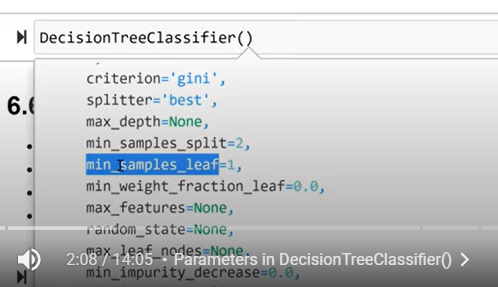

In [237]:
dt = DecisionTreeClassifier(max_depth=6)
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,6
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [238]:
y_pred = dt.predict_proba(X_val)[:, 1]

In [234]:
roc_auc_score(y_val, y_pred)

0.7456800513429076

In [240]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.766
   6 -> 0.745
  10 -> 0.692
  15 -> 0.670
  20 -> 0.661
None -> 0.652


In [241]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747


In [260]:
scores =[]
for m in  [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    print('depth: %s' % m)

    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((m, s, auc))
        print('%s -> %.3f' % (s, auc))
        
    print()



depth: 1
1 -> 0.606
5 -> 0.606
10 -> 0.606
15 -> 0.606
20 -> 0.606
50 -> 0.606
100 -> 0.606
200 -> 0.606

depth: 2
1 -> 0.669
5 -> 0.669
10 -> 0.669
15 -> 0.669
20 -> 0.669
50 -> 0.669
100 -> 0.669
200 -> 0.669

depth: 3
1 -> 0.739
5 -> 0.739
10 -> 0.739
15 -> 0.738
20 -> 0.736
50 -> 0.736
100 -> 0.736
200 -> 0.729

depth: 4
1 -> 0.761
5 -> 0.761
10 -> 0.761
15 -> 0.764
20 -> 0.761
50 -> 0.753
100 -> 0.756
200 -> 0.747

depth: 5
1 -> 0.766
5 -> 0.768
10 -> 0.762
15 -> 0.772
20 -> 0.774
50 -> 0.768
100 -> 0.763
200 -> 0.759

depth: 6
1 -> 0.754
5 -> 0.762
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.772
100 -> 0.776
200 -> 0.768

depth: 10
1 -> 0.687
5 -> 0.721
10 -> 0.768
15 -> 0.790
20 -> 0.786
50 -> 0.776
100 -> 0.780
200 -> 0.768

depth: 15
1 -> 0.661
5 -> 0.713
10 -> 0.759
15 -> 0.787
20 -> 0.784
50 -> 0.776
100 -> 0.780
200 -> 0.768

depth: 20
1 -> 0.637
5 -> 0.707
10 -> 0.765
15 -> 0.787
20 -> 0.783
50 -> 0.776
100 -> 0.780
200 -> 0.768

depth: None
1 -> 0.649
5 -> 0.719
10 -> 0.7

In [261]:
df_scores = pd.DataFrame(scores, columns=['max_depth','min_samples_leaf','auc'])
df_scores.sort_values(by='auc', ascending=False).head()

,max_depth,min_samples_leaf,auc
51,10.0,15,0.789600
59,15.0,15,0.787027
67,20.0,15,0.786658
75,NaN,15,0.786518
52,10.0,20,0.786433


In [262]:
df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values='auc')

max_depth,NaN,1.0,2.0,3.0,4.0,5.0,6.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,,
1,0.648649,0.605864,0.668526,0.738908,0.761283,0.766496,0.754160,0.687450,0.661291,0.637373
5,0.719376,0.605864,0.668526,0.738908,0.761283,0.767755,0.762212,0.721108,0.712979,0.707194
10,0.764473,0.605864,0.668526,0.738908,0.761283,0.761809,0.777521,0.767949,0.758767,0.764834
15,0.786518,0.605864,0.668526,0.737612,0.763726,0.772142,0.785095,0.789600,0.787027,0.786658
20,0.781015,0.605864,0.668526,0.735705,0.760910,0.773537,0.773982,0.786433,0.784345,0.783252
50,0.776440,0.605864,0.668526,0.735705,0.753457,0.768197,0.771733,0.776440,0.776440,0.776440
100,0.779474,0.605864,0.668526,0.735744,0.755937,0.763384,0.776434,0.779725,0.779725,0.779725
200,0.768479,0.605864,0.668808,0.729154,0.747260,0.759073,0.768267,0.768479,0.768479,0.768479


In [263]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values='auc')
df_scores_pivot.round(3)

max_depth,NaN,1.0,2.0,3.0,4.0,5.0,6.0,10.0,15.0,20.0
min_samples_leaf,,,,,,,,,,
1,0.649,0.606,0.669,0.739,0.761,0.766,0.754,0.687,0.661,0.637
5,0.719,0.606,0.669,0.739,0.761,0.768,0.762,0.721,0.713,0.707
10,0.764,0.606,0.669,0.739,0.761,0.762,0.778,0.768,0.759,0.765
15,0.787,0.606,0.669,0.738,0.764,0.772,0.785,0.790,0.787,0.787
20,0.781,0.606,0.669,0.736,0.761,0.774,0.774,0.786,0.784,0.783
50,0.776,0.606,0.669,0.736,0.753,0.768,0.772,0.776,0.776,0.776
100,0.779,0.606,0.669,0.736,0.756,0.763,0.776,0.780,0.780,0.780
200,0.768,0.606,0.669,0.729,0.747,0.759,0.768,0.768,0.768,0.768


<Axes: xlabel='max_depth', ylabel='min_samples_leaf'>

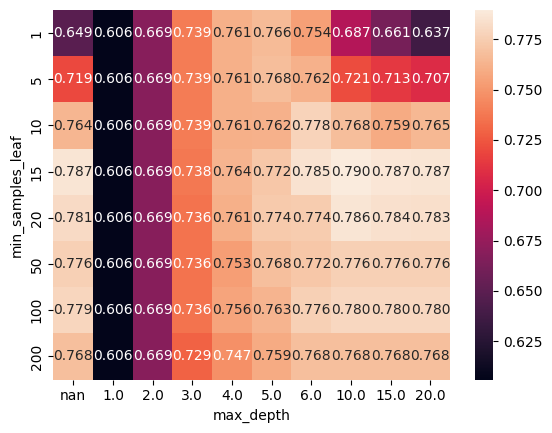

In [264]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [243]:
for m in [1, 5, 10, 15, 20, 50, 100, 200]:
    dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=m)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (m, auc))

1 -> 0.758
5 -> 0.762
10 -> 0.778
15 -> 0.785
20 -> 0.774
50 -> 0.770
100 -> 0.776
200 -> 0.768


In [265]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_dt)

0.7856948245380349

In [266]:
from sklearn.metrics import roc_curve

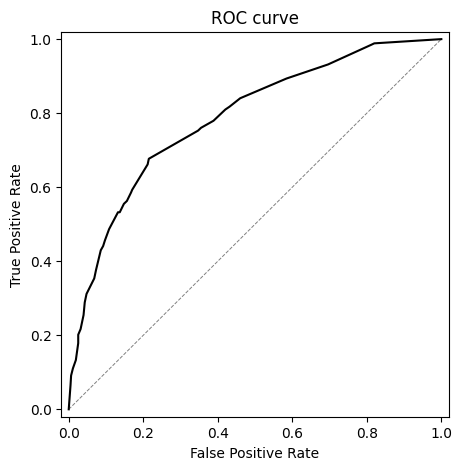

In [267]:
fpr, tpr, _ = roc_curve(y_val, y_pred_dt)

plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, color='black')
plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

# Random forest

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import export_text

In [64]:
rf = RandomForestClassifier(n_estimators=10, random_state=1)
rf.fit(X_train, y_train)


,n_estimators,10
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [65]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7744726453706618

In [66]:
# taking only the first row of xval :

rf.predict_proba(X_val[[0]]) #[:, 1]


array([[0.9, 0.1]])

In [67]:
roc_auc_score(y_val, y_pred)

0.7744726453706618

If we repeat one more time - it changes:

In [68]:
rf = RandomForestClassifier(n_estimators=10)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7875202828703591

In [75]:
aucs = []
scores=[]
for i in range(10, 201, 10):
    
    rf = RandomForestClassifier(n_estimators=i, random_state=1)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)
    scores.append((i, auc))
    print((i, auc))


auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

print('%.3f +- %.3f' % (auc_mean, auc_std))
print('%.3f -- %.3f' % (auc_mean -  auc_std, auc_mean + auc_std))

(10, 0.7744726453706618)
(20, 0.8035316412777603)
(30, 0.8150747136179797)
(40, 0.8156862270228379)
(50, 0.8170818095953114)
(60, 0.8164581870141193)
(70, 0.8173209658279045)
(80, 0.8163068223099464)
(90, 0.8168244895982175)
(100, 0.8175994768835824)
(110, 0.8175268218255793)
(120, 0.8179385338209295)
(130, 0.8182533724056089)
(140, 0.818102007701436)
(150, 0.8172695018284857)
(160, 0.8179809159380979)
(170, 0.8176055314717492)
(180, 0.8174632486498269)
(190, 0.817980915938098)
(200, 0.8190495507495582)
0.814 +- 0.010
0.805 -- 0.824


In [77]:
df_scrores = pd.DataFrame(data=scores, columns= ['no_estimators', 'auc'])


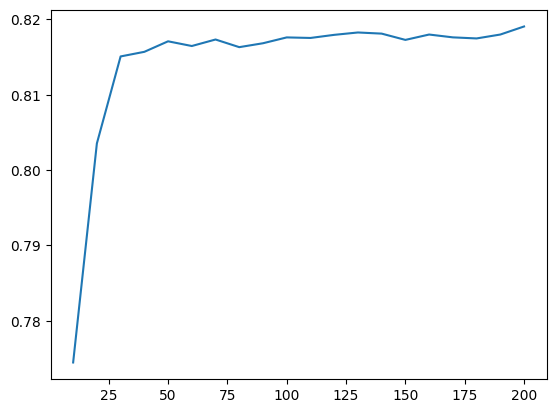

In [78]:
plt.plot(df_scrores.no_estimators, df_scrores.auc)

To understand how much it changes, we can repeat it 100 times and look at the mean and the standard deviation

In [79]:
aucs = []

for i in range(100):
    rf = RandomForestClassifier(n_estimators=10)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    aucs.append(auc)

auc_mean = np.mean(aucs)
auc_std = np.std(aucs)

print('%.3f +- %.3f' % (auc_mean, auc_std))
print('%.3f -- %.3f' % (auc_mean -  auc_std, auc_mean + auc_std))

0.783 +- 0.009
0.773 -- 0.792


To fix this issue, let's set the seed

In [48]:
rf = RandomForestClassifier(n_estimators=10, random_state=3)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7811145285897654

Now we'll check how AUC depends on the number of trees

In [49]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=3)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

10 -> 0.781
20 -> 0.801
30 -> 0.813
40 -> 0.815
50 -> 0.816
60 -> 0.817
70 -> 0.818
80 -> 0.818
90 -> 0.820
100 -> 0.819
110 -> 0.819
120 -> 0.821
130 -> 0.822
140 -> 0.822
150 -> 0.820
160 -> 0.820
170 -> 0.819
180 -> 0.820
190 -> 0.820
200 -> 0.820


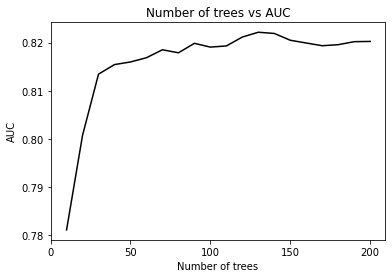

In [50]:
plt.figure(figsize=(6, 4))

plt.plot(range(10, 201, 10), aucs, color='black')
plt.xticks(range(0, 201, 50))

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators.svg')

plt.show()

Tuninig the `max_depth` parameter:

In [82]:
all_aucs = {}
scores= []
for depth in [5, 10, 20]:
    print('depth: %s' % depth)
    aucs = []

    for i in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=i, max_depth=depth, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
        scores.append((depth, i, auc) )
    
    all_aucs[depth] = aucs
    print()
    

depth: 5
10 -> 0.788
20 -> 0.798
30 -> 0.800
40 -> 0.800
50 -> 0.800
60 -> 0.801
70 -> 0.802
80 -> 0.803
90 -> 0.804
100 -> 0.804
110 -> 0.807
120 -> 0.806
130 -> 0.808
140 -> 0.807
150 -> 0.807
160 -> 0.807
170 -> 0.807
180 -> 0.807
190 -> 0.807
200 -> 0.807

depth: 10
10 -> 0.791
20 -> 0.808
30 -> 0.812
40 -> 0.818
50 -> 0.817
60 -> 0.819
70 -> 0.820
80 -> 0.820
90 -> 0.820
100 -> 0.821
110 -> 0.823
120 -> 0.823
130 -> 0.825
140 -> 0.824
150 -> 0.824
160 -> 0.825
170 -> 0.825
180 -> 0.825
190 -> 0.825
200 -> 0.825

depth: 20
10 -> 0.776
20 -> 0.803
30 -> 0.813
40 -> 0.817
50 -> 0.815
60 -> 0.813
70 -> 0.814
80 -> 0.815
90 -> 0.814
100 -> 0.815
110 -> 0.817
120 -> 0.816
130 -> 0.818
140 -> 0.818
150 -> 0.818
160 -> 0.818
170 -> 0.817
180 -> 0.817
190 -> 0.817
200 -> 0.818



In [84]:
df_scores_2 = pd.DataFrame(data=scores, columns = ['depth','estimators','auc'])

In [102]:
#df_scores_2

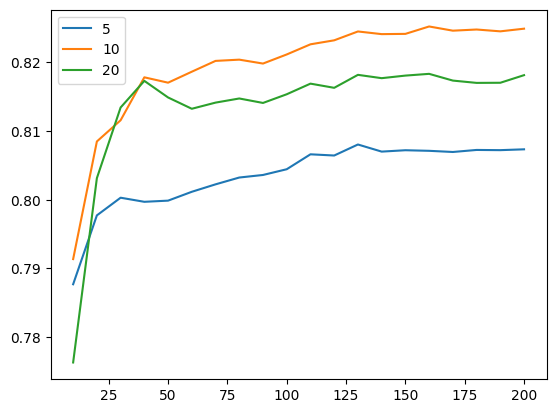

In [95]:
for d in [5,10,20]:
    df_subset =  df_scores_2[df_scores_2.depth ==d]
    plt.plot(df_subset['estimators'], df_subset.auc, label=d )
plt.legend()

In [108]:
# try leaf sze
# next we fix the max_depth and play with s : sample size
max_depth =10

In [123]:
scores= []
for s in [1, 3, 5, 10, 50]:
    print(s, max_depth)
    
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n, 
                                    max_depth=max_depth, 
                                    min_samples_leaf=s,
                                    random_state=1,
                                   n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        #print('%s -> %.3f' % (n, auc))
        
        scores.append((s, n, auc) )
    
    print()
    

1 10

3 10

5 10

10 10

50 10



In [113]:
df_scores_3 = pd.DataFrame(data=scores, columns = ['min_samples_leaf','estimators','auc'])

In [116]:
df_subset =  df_scores_3[df_scores_3.min_samples_leaf ==1]
#df_subset

In [118]:
min_samples_leaf_values =[1, 3, 5, 10, 50] 
colors= ['black','blue','orange','red','grey']
list(zip(min_samples_leaf_values, colors))

[(1, 'black'), (3, 'blue'), (5, 'orange'), (10, 'red'), (50, 'grey')]

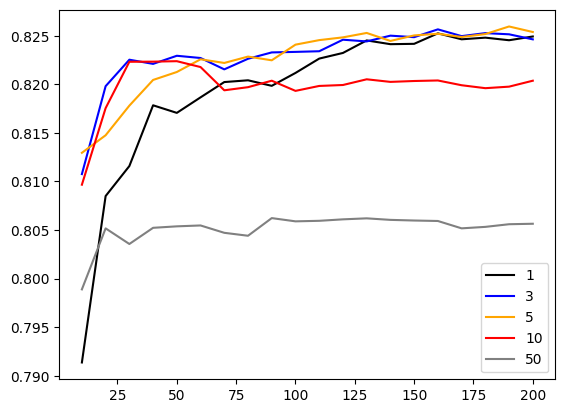

In [119]:

for s, c in zip(min_samples_leaf_values, colors):
    df_subset =  df_scores_3[df_scores_3.min_samples_leaf ==s]
    plt.plot(df_subset['estimators'], df_subset.auc, label=s, color=c )
plt.legend()

In [121]:
min_sample_leaf=3
#with 100 estimators

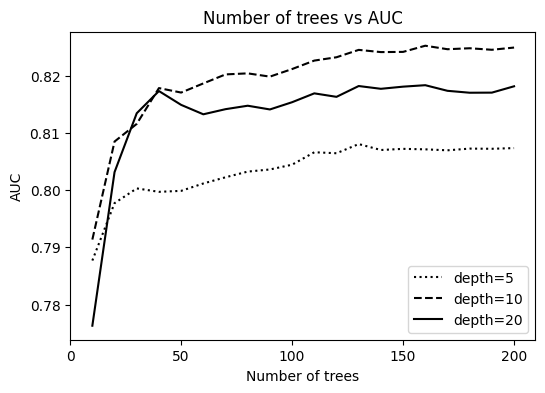

In [122]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 10))

plt.plot(num_trees, all_aucs[5], label='depth=5', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[10], label='depth=10', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[20], label='depth=20', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_depth.svg')

plt.show()

Tuning the `min_samples_leaf` parameter

In [124]:
all_aucs = {}

for m in [3, 5, 10]:
    print('min_samples_leaf: %s' % m)
    aucs = []

    for i in range(10, 201, 20):
        rf = RandomForestClassifier(n_estimators=i, max_depth=10, min_samples_leaf=m, random_state=1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        print('%s -> %.3f' % (i, auc))
        aucs.append(auc)
    
    all_aucs[m] = aucs
    print()

min_samples_leaf: 3
10 -> 0.811
30 -> 0.823
50 -> 0.823
70 -> 0.822
90 -> 0.823
110 -> 0.823
130 -> 0.824
150 -> 0.825
170 -> 0.825
190 -> 0.825

min_samples_leaf: 5
10 -> 0.813
30 -> 0.818
50 -> 0.821
70 -> 0.822
90 -> 0.822
110 -> 0.825
130 -> 0.825
150 -> 0.825
170 -> 0.825
190 -> 0.826

min_samples_leaf: 10
10 -> 0.810
30 -> 0.822
50 -> 0.822
70 -> 0.819
90 -> 0.820
110 -> 0.820
130 -> 0.821
150 -> 0.820
170 -> 0.820
190 -> 0.820



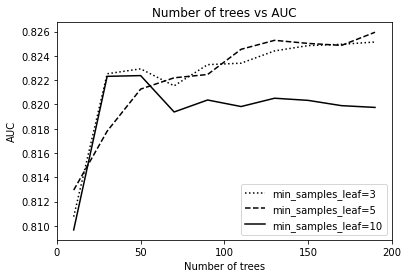

In [54]:
plt.figure(figsize=(6, 4))

num_trees = list(range(10, 201, 20))

plt.plot(num_trees, all_aucs[3], label='min_samples_leaf=3', color='black', linestyle='dotted')
plt.plot(num_trees, all_aucs[5], label='min_samples_leaf=5', color='black', linestyle='dashed')
plt.plot(num_trees, all_aucs[10], label='min_samples_leaf=10', color='black', linestyle='solid')
    
plt.xticks(range(0, 201, 50))
plt.legend()

plt.title('Number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_random_forest_n_estimators_sample_leaf.svg')

plt.show()

Training the final model:

In [55]:
rf = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_estimators=200,
                       random_state=1)

In [56]:
y_pred_rf = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred_rf)

0.8253826499721489

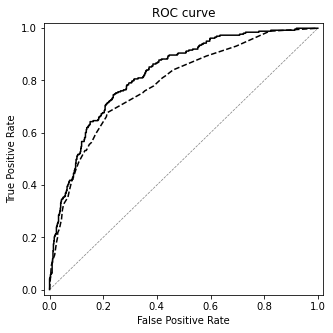

In [57]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='black')

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='black', linestyle='dashed')

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

## XGBoost

In [126]:
!pip install xgboost

   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/72.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/72.0 MB 3.1 MB/s eta 0:00:24
    --------------------------------------- 1.3/72.0 MB 3.4 MB/s eta 0:00:21
    --------------------------------------- 1.6/72.0 MB 3.5 MB/s eta 0:00:21
   - -------------------------------------- 2.6/72.0 MB 3.1 MB/s eta 0:00:23
   - -------------------------------------- 2.6/72.0 MB 3.1 MB/s eta 0:00:23
   -- ------------------------------------- 3.9/72.0 MB 3.2 MB/s eta 0:00:22
   -- ------------------------------------- 4.7/72.0 MB 3.3 MB/s eta 0:00:21
   --- ------------------------------------ 5.5/72.0 MB 3.3 MB/s eta 0:00:20
   --- ------------------------------------ 6.3/72.0 MB 3.3 MB/s eta 0:00:20
   --- ------------------------------------ 6.6/72.0 MB 3.3 MB/s eta 0:00:20
   ---- ----------------------------------- 7.3/72.0 MB 3.2 MB/s eta 0:00:21
   ---- -----

In [137]:
import xgboost as xgb

### wrap our data in a special data structure  dMatrix

In [138]:
features = dv.get_feature_names_out()
features

array(['age', 'amount', 'assets', 'debt', 'expenses', 'home=ignore',
       'home=other', 'home=owner', 'home=parents', 'home=private',
       'home=rent', 'home=unk', 'income', 'job=fixed', 'job=freelance',
       'job=others', 'job=partime', 'job=unk', 'marital=divorced',
       'marital=married', 'marital=separated', 'marital=single',
       'marital=unk', 'marital=widow', 'price', 'records=no',
       'records=yes', 'seniority', 'time'], dtype=object)

In [139]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)

In [143]:
xgb_params = {
    'eta': 0.3, #learning rate
    'max_depth': 6,
    'min_child_weight': 1, 

    'objective': 'binary:logistic',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

In [144]:
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [145]:
y_pred = model.predict(dval)
y_pred[:10]

array([0.05866029, 0.06297418, 0.07957753, 0.12453752, 0.05471457,
       0.10543569, 0.04962284, 0.34493914, 0.62430215, 0.02429806],
      dtype=float32)

In [147]:
roc_auc_score(y_val, y_pred)

0.8118506454190986

In [148]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [151]:
xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
    'verbosity':1
}

In [156]:
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=200,
                  
                  evals=watchlist, verbose_eval=5)

[0]	train-auc:0.86653	val-auc:0.77999
[5]	train-auc:0.92969	val-auc:0.80822
[10]	train-auc:0.95512	val-auc:0.81115
[15]	train-auc:0.96767	val-auc:0.81993
[20]	train-auc:0.97648	val-auc:0.81877
[25]	train-auc:0.98248	val-auc:0.81520
[30]	train-auc:0.98844	val-auc:0.81613
[35]	train-auc:0.99244	val-auc:0.81453
[40]	train-auc:0.99393	val-auc:0.81407
[45]	train-auc:0.99568	val-auc:0.81392
[50]	train-auc:0.99723	val-auc:0.81276
[55]	train-auc:0.99804	val-auc:0.81299
[60]	train-auc:0.99861	val-auc:0.81244
[65]	train-auc:0.99916	val-auc:0.81197
[70]	train-auc:0.99962	val-auc:0.81243
[75]	train-auc:0.99975	val-auc:0.81152
[80]	train-auc:0.99989	val-auc:0.81359
[85]	train-auc:0.99993	val-auc:0.81193
[90]	train-auc:0.99998	val-auc:0.81038
[95]	train-auc:0.99999	val-auc:0.80871
[100]	train-auc:0.99999	val-auc:0.80842
[105]	train-auc:1.00000	val-auc:0.80778
[110]	train-auc:1.00000	val-auc:0.80764
[115]	train-auc:1.00000	val-auc:0.80722
[120]	train-auc:1.00000	val-auc:0.80750
[125]	train-auc:1.0000

To capture this output, we can use 

- `%%capture` instruction that saves the result to `output`
- `parse_xgb_output` function that parses it

In [153]:
%%capture output

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=5)

In [159]:
s = output.stdout

In [164]:
line = s.split('\n')[0]

num_iter, train_auc, val_auc = line.split('\t')
num_iter, train_auc, val_auc

('[0]', 'train-auc:0.86653', 'val-auc:0.77999')

In [167]:
int(num_iter.strip('[]'))

0

In [170]:
float(train_auc.split(':')[1])

0.86653

In [171]:
float(val_auc.split(':')[1])

0.77999

In [183]:
def parse_xgb_output(output):
    results=[]
    tree = []
    aucs_train = []
    aucs_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
        tree.append(it)
        aucs_train.append(train)
        aucs_val.append(val)
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results=pd.DataFrame(data=results, columns= columns)
    return tree, aucs_train, aucs_val, df_results

Let's use it for plotting the scores

In [184]:
tree, aucs_train, aucs_val , results_df= parse_xgb_output(output)

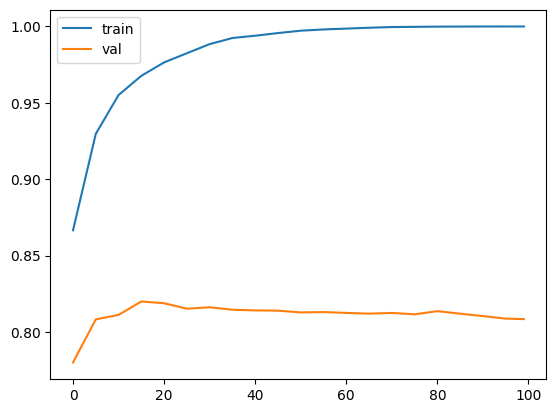

In [190]:
plt.plot(results_df.num_iter, results_df.train_auc, label='train')
plt.plot(results_df.num_iter, results_df.val_auc, label='val')
plt.legend()

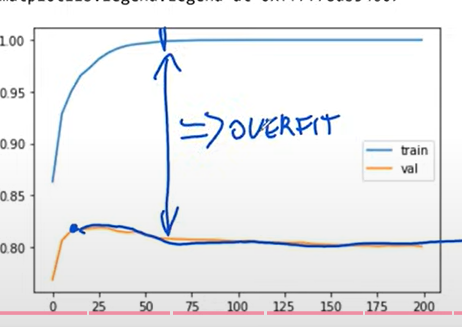

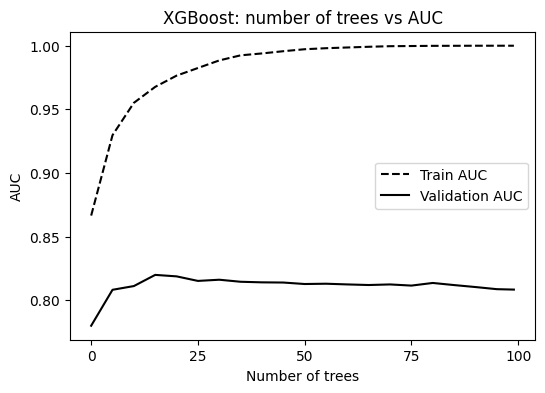

In [191]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_train, color='black', linestyle='dashed', label='Train AUC')
plt.plot(tree, aucs_val, color='black', linestyle='solid', label='Validation AUC')
plt.xticks(range(0, 101, 25))

plt.legend()

plt.title('XGBoost: number of trees vs AUC')
plt.xlabel('Number of trees')
plt.ylabel('AUC')

# plt.savefig('ch06-figures/06_xgb_default.svg')

plt.show()

### Parameter tuning: eta

First, we try to set eta to 0.1

In [192]:
%%capture output

xgb_params = {
    'eta': 0.3,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [72]:
tree, _, aucs_val_eta_03 = parse_xgb_output(output)
print(max(aucs_val_eta_03))
print(max(zip(aucs_val_eta_03, tree)))

0.81788
(0.81788, 30)


In [73]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [74]:
tree, _, aucs_val_eta_01 = parse_xgb_output(output)
print(max(aucs_val_eta_01))
print(max(zip(aucs_val_eta_01, tree)))

0.82476
(0.82476, 70)


In [75]:
%%capture output

xgb_params = {
    'eta': 0.05,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [76]:
tree, _, aucs_val_eta_005 = parse_xgb_output(output)
print(max(aucs_val_eta_005))
print(max(zip(aucs_val_eta_005, tree)))

0.82297
(0.82297, 120)


In [77]:
%%capture output

xgb_params = {
    'eta': 0.01,
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [78]:
tree, _, aucs_val_eta_001 = parse_xgb_output(output)
print(max(aucs_val_eta_001))
print(max(zip(aucs_val_eta_001, tree)))

0.82168
(0.82168, 499)


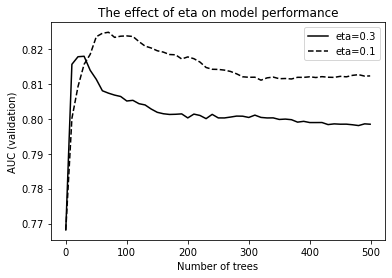

In [79]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_03, color='black', linestyle='solid', label='eta=0.3')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='dashed', label='eta=0.1')
# plt.plot(tree, aucs_val_eta_005, color='grey', linestyle='solid', label='eta=0.05')
# plt.plot(tree, aucs_val_eta_001, color='grey', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_eta.svg')

plt.show()

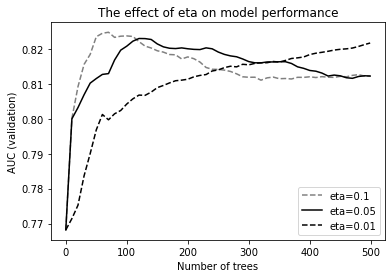

In [80]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_eta_01, color='grey', linestyle='dashed', label='eta=0.1')
plt.plot(tree, aucs_val_eta_005, color='black', linestyle='solid', label='eta=0.05')
plt.plot(tree, aucs_val_eta_001, color='black', linestyle='dashed', label='eta=0.01')

plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of eta on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_eta_2.svg')

plt.show()

### Parameter tuning: max_depth

First, try 3

In [81]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [82]:
tree, _, aucs_val_depth3 = parse_xgb_output(output)
print(max(aucs_val_depth3))
print(max(zip(aucs_val_depth3, tree)))

0.83657
(0.83657, 180)


Now, try 10

In [83]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 10,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [84]:
tree, _, aucs_val_depth10 = parse_xgb_output(output)
print(max(aucs_val))
print(max(zip(aucs_val_depth10, tree)))

0.81878
(0.81169, 100)


With depth=3 it's better than depth=6 and depth=10. So let's try 4 to see if it's better than 3

In [85]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 4,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [86]:
tree, _, aucs_val_depth4 = parse_xgb_output(output)
print(max(aucs_val_depth4))
print(max(zip(aucs_val_depth4, tree)))

0.83014
(0.83014, 80)


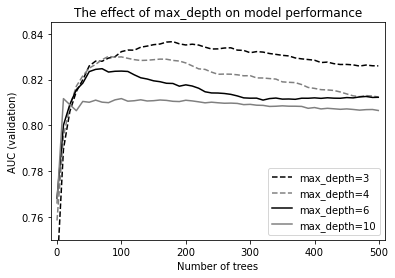

In [87]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_depth3, color='black', linestyle='dashed', label='max_depth=3')
plt.plot(tree, aucs_val_depth4, color='grey', linestyle='dashed', label='max_depth=4')
plt.plot(tree, aucs_val_eta_01, color='black', linestyle='solid', label='max_depth=6')
plt.plot(tree, aucs_val_depth10, color='grey', linestyle='solid', label='max_depth=10')

plt.ylim(0.75, 0.845)
plt.xlim(-10, 510)
plt.xticks(range(0, 501, 100))

plt.legend()

plt.title('The effect of max_depth on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_depth.svg')

plt.show()

It's not better, so we'll leave it at 3

### Tune "min_child_weight"

First, the default value:

In [88]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [89]:
tree, _, aucs_val_mcw1 = parse_xgb_output(output)
print(max(aucs_val_mcw1))
print(max(zip(aucs_val_mcw1, tree)))

0.83657
(0.83657, 180)


In [90]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 10,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [91]:
tree, _, aucs_val_mcw10 = parse_xgb_output(output)
print(max(aucs_val_mcw10))
print(max(zip(aucs_val_mcw10, tree)))

0.83336
(0.83336, 150)


In [92]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [93]:
tree, _, aucs_val_mcw30 = parse_xgb_output(output)
print(max(aucs_val_mcw30))
print(max(zip(aucs_val_mcw30, tree)))

0.83543
(0.83543, 160)


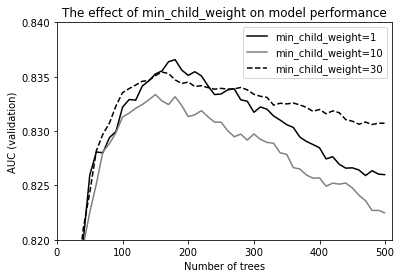

In [94]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val_mcw1, color='black', linestyle='solid', label='min_child_weight=1')
plt.plot(tree, aucs_val_mcw10, color='grey', linestyle='solid', label='min_child_weight=10')
plt.plot(tree, aucs_val_mcw30, color='black', linestyle='dashed', label='min_child_weight=30')

plt.ylim(0.82, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.82, 0.84, 5))

plt.legend()

plt.title('The effect of min_child_weight on model performance')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_mcw.svg')

plt.show()

## Checking the best number of trees

In [95]:
%%capture output

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=500, verbose_eval=10,
                  evals=watchlist)

In [96]:
print(output)

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82807
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[180]	train-auc:0.93971	val-auc:0.83657
[190]	train-auc:0.94203	val-auc:0.83562
[200]	train-auc:0.94334	val-auc:0.83512
[210]	train-auc:0.94501	val-auc:0.83546
[220]	train-auc:0.94693	val-auc:0.83508
[230]	train-auc:0.94839	val-auc:0.83417
[240]	train-auc:0.94999	val-auc:0.83336
[250]	train

In [97]:
tree, _, aucs_val = parse_xgb_output(output)
print(max(aucs_val))

0.83657


In [98]:
max(zip(aucs_val, tree))

(0.83657, 180)

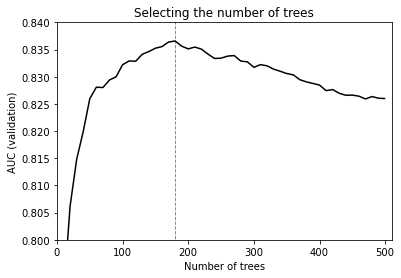

In [99]:
plt.figure(figsize=(6, 4))

plt.plot(tree, aucs_val, color='black', linestyle='solid')


plt.ylim(0.80, 0.84)
plt.xlim(0, 510)
plt.xticks(range(0, 501, 100))
plt.yticks(np.linspace(0.80, 0.84, 9))


plt.vlines(180, 0, 1, color='grey', linestyle='dashed', linewidth=0.9)

plt.title('Selecting the number of trees')
plt.xlabel('Number of trees')
plt.ylabel('AUC (validation)')

# plt.savefig('ch06-figures/06_xgb_number_trees.svg')

plt.show()

Final model

In [100]:
xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

model = xgb.train(xgb_params, dtrain,
                  num_boost_round=180, verbose_eval=10,
                  evals=watchlist)

[0]	train-auc:0.77424	val-auc:0.73571
[10]	train-auc:0.84733	val-auc:0.78964
[20]	train-auc:0.86359	val-auc:0.80617
[30]	train-auc:0.87855	val-auc:0.81478
[40]	train-auc:0.88701	val-auc:0.81990
[50]	train-auc:0.89458	val-auc:0.82595
[60]	train-auc:0.90159	val-auc:0.82807
[70]	train-auc:0.90650	val-auc:0.82801
[80]	train-auc:0.91110	val-auc:0.82940
[90]	train-auc:0.91428	val-auc:0.82997
[100]	train-auc:0.91801	val-auc:0.83221
[110]	train-auc:0.92205	val-auc:0.83290
[120]	train-auc:0.92460	val-auc:0.83285
[130]	train-auc:0.92843	val-auc:0.83414
[140]	train-auc:0.93100	val-auc:0.83463
[150]	train-auc:0.93296	val-auc:0.83525
[160]	train-auc:0.93551	val-auc:0.83554
[170]	train-auc:0.93788	val-auc:0.83638
[179]	train-auc:0.93962	val-auc:0.83648


In [101]:
y_pred_xgb = model.predict(dval)

In [102]:
roc_auc_score(y_val, y_pred_xgb)

0.8364807100821002

In [103]:
print(roc_auc_score(y_val, y_pred_dt))
print(roc_auc_score(y_val, y_pred_rf))
print(roc_auc_score(y_val, y_pred_xgb))

0.7854738320699426
0.8253826499721489
0.8364807100821002


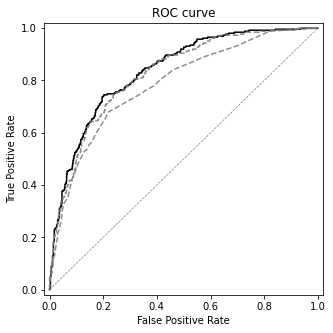

In [104]:
plt.figure(figsize=(5, 5))

fpr, tpr, _ = roc_curve(y_val, y_pred_xgb)
plt.plot(fpr, tpr, color='black')

fpr, tpr, _ = roc_curve(y_val, y_pred_rf)
plt.plot(fpr, tpr, color='grey', linestyle='dashed', alpha=0.9)

fpr, tpr, _ = roc_curve(y_val, y_pred_dt)
plt.plot(fpr, tpr, color='grey', linestyle='dashed', alpha=0.9)

plt.plot([0, 1], [0, 1], color='black', lw=0.7, linestyle='dashed', alpha=0.5)

plt.xlim([-0.02, 1.02])
plt.ylim([-0.02, 1.02])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('ROC curve')

plt.show()

## Final test

In [105]:
y_train_full = (df_train_full.status == 'default').values
y_test = (df_test.status == 'default').values

del df_train_full['status']
del df_test['status']

In [106]:
dict_train_full = df_train_full.fillna(0).to_dict(orient='records')
dict_test = df_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dict_train_full)
X_test = dv.transform(dict_test)

In [107]:
rf_final = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, random_state=1)
rf_final.fit(X_train_full, y_train_full)

y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [108]:
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, feature_names=dv.feature_names_)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=dv.feature_names_)

xgb_params = {
    'eta': 0.1,
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'nthread': 8,
    'seed': 1,
}

num_trees = 160

xgb_final = xgb.train(xgb_params, dtrain_full, num_boost_round=num_trees)

In [109]:
y_pred_xgb = xgb_final.predict(dtest)

In [110]:
print(roc_auc_score(y_test, y_pred_rf))
print(roc_auc_score(y_test, y_pred_xgb))

0.8241777039245393
0.8322845901959826


## Bonus: feature importance

### Decision trees

In [111]:
dt.feature_importances_

array([0.01387723, 0.04793733, 0.1226385 , 0.00833288, 0.0250906 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.18724799, 0.00699145, 0.        ,
       0.        , 0.17292753, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.0302163 ,
       0.        , 0.24421676, 0.12152239, 0.01900104])

In [112]:
list(zip(dv.feature_names_, dt.feature_importances_))

[('age', 0.013877231876069153),
 ('amount', 0.04793733336664824),
 ('assets', 0.12263850423922844),
 ('debt', 0.008332876385504902),
 ('expenses', 0.025090602575881322),
 ('home=ignore', 0.0),
 ('home=other', 0.0),
 ('home=owner', 0.0),
 ('home=parents', 0.0),
 ('home=private', 0.0),
 ('home=rent', 0.0),
 ('home=unk', 0.0),
 ('income', 0.18724798934476602),
 ('job=fixed', 0.006991445659436667),
 ('job=freelance', 0.0),
 ('job=others', 0.0),
 ('job=partime', 0.17292752964348085),
 ('job=unk', 0.0),
 ('marital=divorced', 0.0),
 ('marital=married', 0.0),
 ('marital=separated', 0.0),
 ('marital=single', 0.0),
 ('marital=unk', 0.0),
 ('marital=widow', 0.0),
 ('price', 0.030216298419676543),
 ('records=no', 0.0),
 ('records=yes', 0.24421675762093445),
 ('seniority', 0.12152238957522045),
 ('time', 0.019001041293152915)]

In [113]:
importances = list(zip(dv.feature_names_, dt.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
26,records=yes,0.244217
12,income,0.187248
16,job=partime,0.172928
2,assets,0.122639
27,seniority,0.121522
1,amount,0.047937
24,price,0.030216
4,expenses,0.025091
28,time,0.019001
0,age,0.013877


In [114]:
df_importance = df_importance[df_importance.gain > 0]

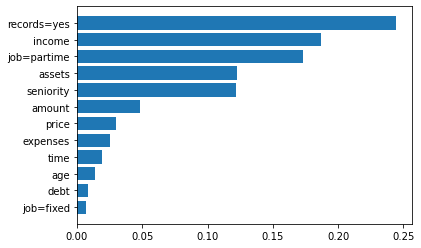

In [115]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

### Random forest

In [116]:
rf.feature_importances_

array([5.81509463e-02, 8.42444361e-02, 7.75901403e-02, 1.33739427e-02,
       3.62995916e-02, 1.26998064e-06, 5.25854792e-03, 2.57383446e-02,
       8.51497558e-03, 3.24437831e-03, 1.44619658e-02, 0.00000000e+00,
       1.50682384e-01, 4.78310889e-02, 9.96408243e-03, 2.85512508e-03,
       5.65260797e-02, 0.00000000e+00, 2.43128646e-04, 6.42996557e-03,
       1.68784119e-03, 6.67458246e-03, 0.00000000e+00, 1.97498337e-04,
       6.62193254e-02, 8.41683921e-02, 8.30420483e-02, 1.25453198e-01,
       3.11467205e-02])

In [117]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))

df_importance = pd.DataFrame(importances, columns=['feature', 'gain'])
df_importance = df_importance.sort_values(by='gain', ascending=False)
df_importance

,feature,gain
12,income,0.150682
27,seniority,0.125453
1,amount,0.084244
25,records=no,0.084168
26,records=yes,0.083042
2,assets,0.077590
24,price,0.066219
0,age,0.058151
16,job=partime,0.056526
13,job=fixed,0.047831


In [118]:
df_importance = df_importance[df_importance.gain > 0.01]

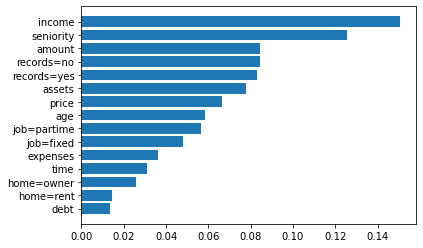

In [119]:
num = len(df_importance)
plt.barh(range(num), df_importance.gain[::-1])
plt.yticks(range(num), df_importance.feature[::-1])

plt.show()

### XGBoost

In [120]:
scores = model.get_score(importance_type='gain')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('records=no', 20.205886174933337),
 ('job=partime', 19.571840249333327),
 ('job=fixed', 14.703467482368419),
 ('home=owner', 12.168287986666668),
 ('seniority', 10.93204644173191),
 ('income', 8.676314024586466),
 ('assets', 5.918307806556342),
 ('amount', 5.400780562827161),
 ('time', 5.0175909627586215),
 ('home=parents', 4.499092019090908),
 ('home=rent', 4.028717651875),
 ('price', 3.7946846306606075),
 ('expenses', 3.589669993872826),
 ('age', 3.318183602467891),
 ('debt', 2.9418528487777773),
 ('marital=separated', 2.641880279076923),
 ('home=private', 2.4620430769999997),
 ('marital=married', 2.427789335636364),
 ('home=other', 2.3016982833333333),
 ('job=freelance', 2.25929752),
 ('job=others', 1.61876595),
 ('home=ignore', 0.7887506362000001)]

In [121]:
scores = model.get_score(importance_type='weight')
scores = sorted(scores.items(), key=lambda x: x[1])
list(reversed(scores))

[('price', 165),
 ('amount', 162),
 ('assets', 142),
 ('income', 133),
 ('seniority', 119),
 ('age', 109),
 ('expenses', 92),
 ('debt', 63),
 ('records=no', 60),
 ('time', 29),
 ('home=parents', 22),
 ('job=partime', 21),
 ('job=fixed', 19),
 ('marital=separated', 13),
 ('home=private', 12),
 ('marital=married', 11),
 ('home=rent', 8),
 ('home=owner', 6),
 ('home=ignore', 5),
 ('job=freelance', 4),
 ('home=other', 3),
 ('job=others', 1)]

In [122]:
names = [n for (n, s) in scores]
scores = [s for (n, s) in scores]

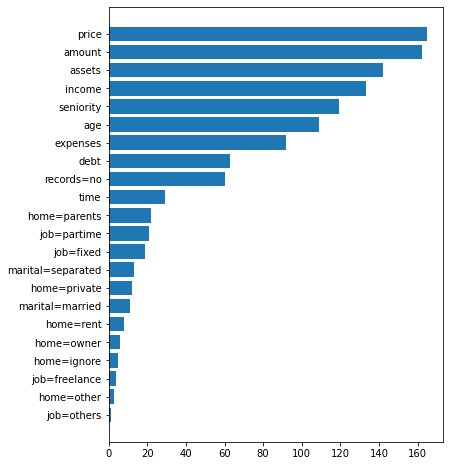

In [123]:
plt.figure(figsize=(6, 8))

plt.barh(np.arange(len(scores)), scores)
plt.yticks(np.arange(len(names)), names)

plt.show()

## Bonus: Extremely randomized trees

Similar to random forest, but more random. Instead of selecting the best split among all posible splits, ET picks a few candidate splits at random and then select the best one among them.

In [124]:
from sklearn.ensemble import ExtraTreesClassifier

In [125]:
aucs = []

for i in range(10, 201, 10):
    rf = ExtraTreesClassifier(n_estimators=i, max_depth=30)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

10 -> 0.765
20 -> 0.785
30 -> 0.786
40 -> 0.782
50 -> 0.786
60 -> 0.790
70 -> 0.790
80 -> 0.791
90 -> 0.794
100 -> 0.790
110 -> 0.800
120 -> 0.787
130 -> 0.798
140 -> 0.792
150 -> 0.794
160 -> 0.796
170 -> 0.800
180 -> 0.797
190 -> 0.797
200 -> 0.797
